In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
!pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
import os


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# Set a fixed random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def coef_pval(coef_array_mean_, X_, y_, y_p):
    n = X_.shape[0]
    t = coef_tval(coef_array_mean_, X_, y_, y_p)
    p = 2 * (1 - scipy.stats.t.cdf(abs(t), n - 1))
    return p

def coef_tval(coef_array_mean_, X_, y_, y_p):
    se = coef_se(X_, y_, y_p)
    a = np.array(coef_array_mean_[0][0] / se[0])
    b = np.array(coef_array_mean_[1::].flatten() / se[1:])
    return np.append(a, b)

def coef_se(X_, y_, y_p):
    n = X_.shape[0]
    X1 = np.hstack((np.ones((n, 1)), np.matrix(X_)))
    se_matrix = scipy.linalg.sqrtm(
        mean_squared_error(y_, y_p) *
        np.linalg.inv(X1.T * X1)
    )
    return np.diag(se_matrix)

def Regression_Linear(X, y, min_, max_, n_splits, model):
    scaler = MinMaxScaler(feature_range=(0.05, 0.95))
    scaling_data = scaler.fit_transform(X)
    X = pd.DataFrame(scaling_data, columns=X.columns, index=X.index)

    for i in range(min_, max_):
        y_pred_ = []
        y_test_ = []
        r_squared_l = []
        rmse_l = []
        mse_l = []

        results_labels_df = pd.DataFrame(columns=['y_labels', 'y_pred', 'ID'])

        r_squared_ = 0
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
        lista_vars = list(X)

        coef_array = np.zeros([len(lista_vars) + 1, n_splits])
        iter_ = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train)

            coef_array[0, iter_] = model.intercept_
            coef_array[1::, iter_] = model.coef_

            y_pred_.extend(model.predict(X_test))
            y_test_.extend(y_test)

            result = np.column_stack((y_test, model.predict(X_test)))
            temp_df = pd.DataFrame(result, columns=['y_labels', 'y_pred'])
            temp_df['ID'] = X_test.index
            results_labels_df = pd.concat(
                [results_labels_df, temp_df], ignore_index=True)

            r_squared_ = r2_score(y_test, model.predict(X_test))
            rmse_l.append(np.round(mean_squared_error(
                y_test, model.predict(X_test)), 6))
            mse_l.append(
                np.round(math.sqrt(mean_squared_error(y_test, model.predict(X_test))), 6))
            r_squared_l.append(r_squared_)
            iter_ += 1

        n = X.shape[0]
        p = X.shape[1]
        r_squared = r2_score(y_test_, y_pred_)

        k = X.shape[1] - 1
        r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
        mse = (np.round(mean_squared_error(y_test_, y_pred_), 6))
        rmse = (np.round(math.sqrt(mean_squared_error(y_test_, y_pred_)), 6))

        F = (r_squared / p) / ((1 - r_squared) / (n - p - 1))
        p_value = np.round(scipy.stats.f.sf(F, n, (n - p - 1)), 15)

        F2 = r_squared / (1 - r_squared)

        coef_array_mean = np.zeros([len(lista_vars) + 1, 1])
        coef_array_std = np.zeros([len(lista_vars) + 1, 1])

        for j in range(len(lista_vars) + 1):
            coef_array_mean[j] = coef_array[j, :].mean()
            coef_array_std[j] = coef_array[j, :].std()

        coef_df = pd.DataFrame(index=['_intercept'] + lista_vars, columns=[
                               'Estimate mean', 'Estimate std', 't value', 'p value'])
        coef_df['Estimate mean'] = coef_array_mean
        coef_df['Estimate std'] = coef_array_std
        coef_df['t value'] = coef_tval(coef_array_mean, X, y_test_, y_pred_)
        coef_df['p value'] = coef_pval(coef_array_mean, X, y_test_, y_pred_)

        coef_df.loc['_intercept', 'R2'] = r_squared
        coef_df.loc['_intercept', 'R2 adj'] = r_squared_adj
        coef_df.loc['_intercept', 'R2 [+-]'] = 1.96 * np.std(r_squared_l)
        coef_df.loc['_intercept', 'F2'] = F2
        coef_df.loc['_intercept', 'mse'] = mse
        coef_df.loc['_intercept', 'mse [+-]'] = 1.96 * np.std(mse_l)
        coef_df.loc['_intercept', 'rmse'] = rmse
        coef_df.loc['_intercept', 'rmse [+-]'] = 1.96 * np.std(rmse_l)
        coef_df.loc['_intercept', 'outcome var'] = np.var(y)
        coef_df.loc['_intercept', 'F'] = F
        coef_df.loc['_intercept', 'F-p_value'] = p_value

    return [coef_df, r_squared, results_labels_df]

In [ ]:

df = pd.read_excel('GERO_Chile_cohort_biomarker_may2024.xlsx')
df_cn_vs = df.copy()
df_cn_vs['diagnosis'] = df_cn_vs['diagnosis'].map({'CN': 0, 'AD': 1, 'MCI':2, 'QS':3})
df_cn_vs
#
#df_cn_vs['diagnosis'] = df_cn_vs['diagnosis'].map({'CN': 0, 'QS':1, 'MCI':2,'AD': 3})




TypeError: PsmPy.__init__() got an unexpected keyword argument 'neighbors'

In [ ]:
predictors = ["Aβ42/Aβ40 ratio", "GFAP", "NfL", "p-tau217"]#, "Sex", "Age", "Education","Diagnosis"]
y_columns = ["Global cognition", "Functionality", "Memory"]#, "Attention",	"Language",	"Visuospatial",	"Executive function",	"Social cognition"]

In [ ]:

max_val = df_cn_vs['Attention'].max()
min_val = df_cn_vs['Attention'].min()
df_cn_vs['Attention'] = max_val + min_val - df['Attention']

max_val = df_cn_vs['Functionality'].max()
min_val = df_cn_vs['Functionality'].min()
df_cn_vs['Functionality'] = max_val + min_val - df['Functionality']

<ipython-input-2-46891e3ccc7e>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df = pd.concat(
<ipython-input-2-46891e3ccc7e>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df = pd.concat(
<ipython-input-2-46891e3ccc7e>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclu

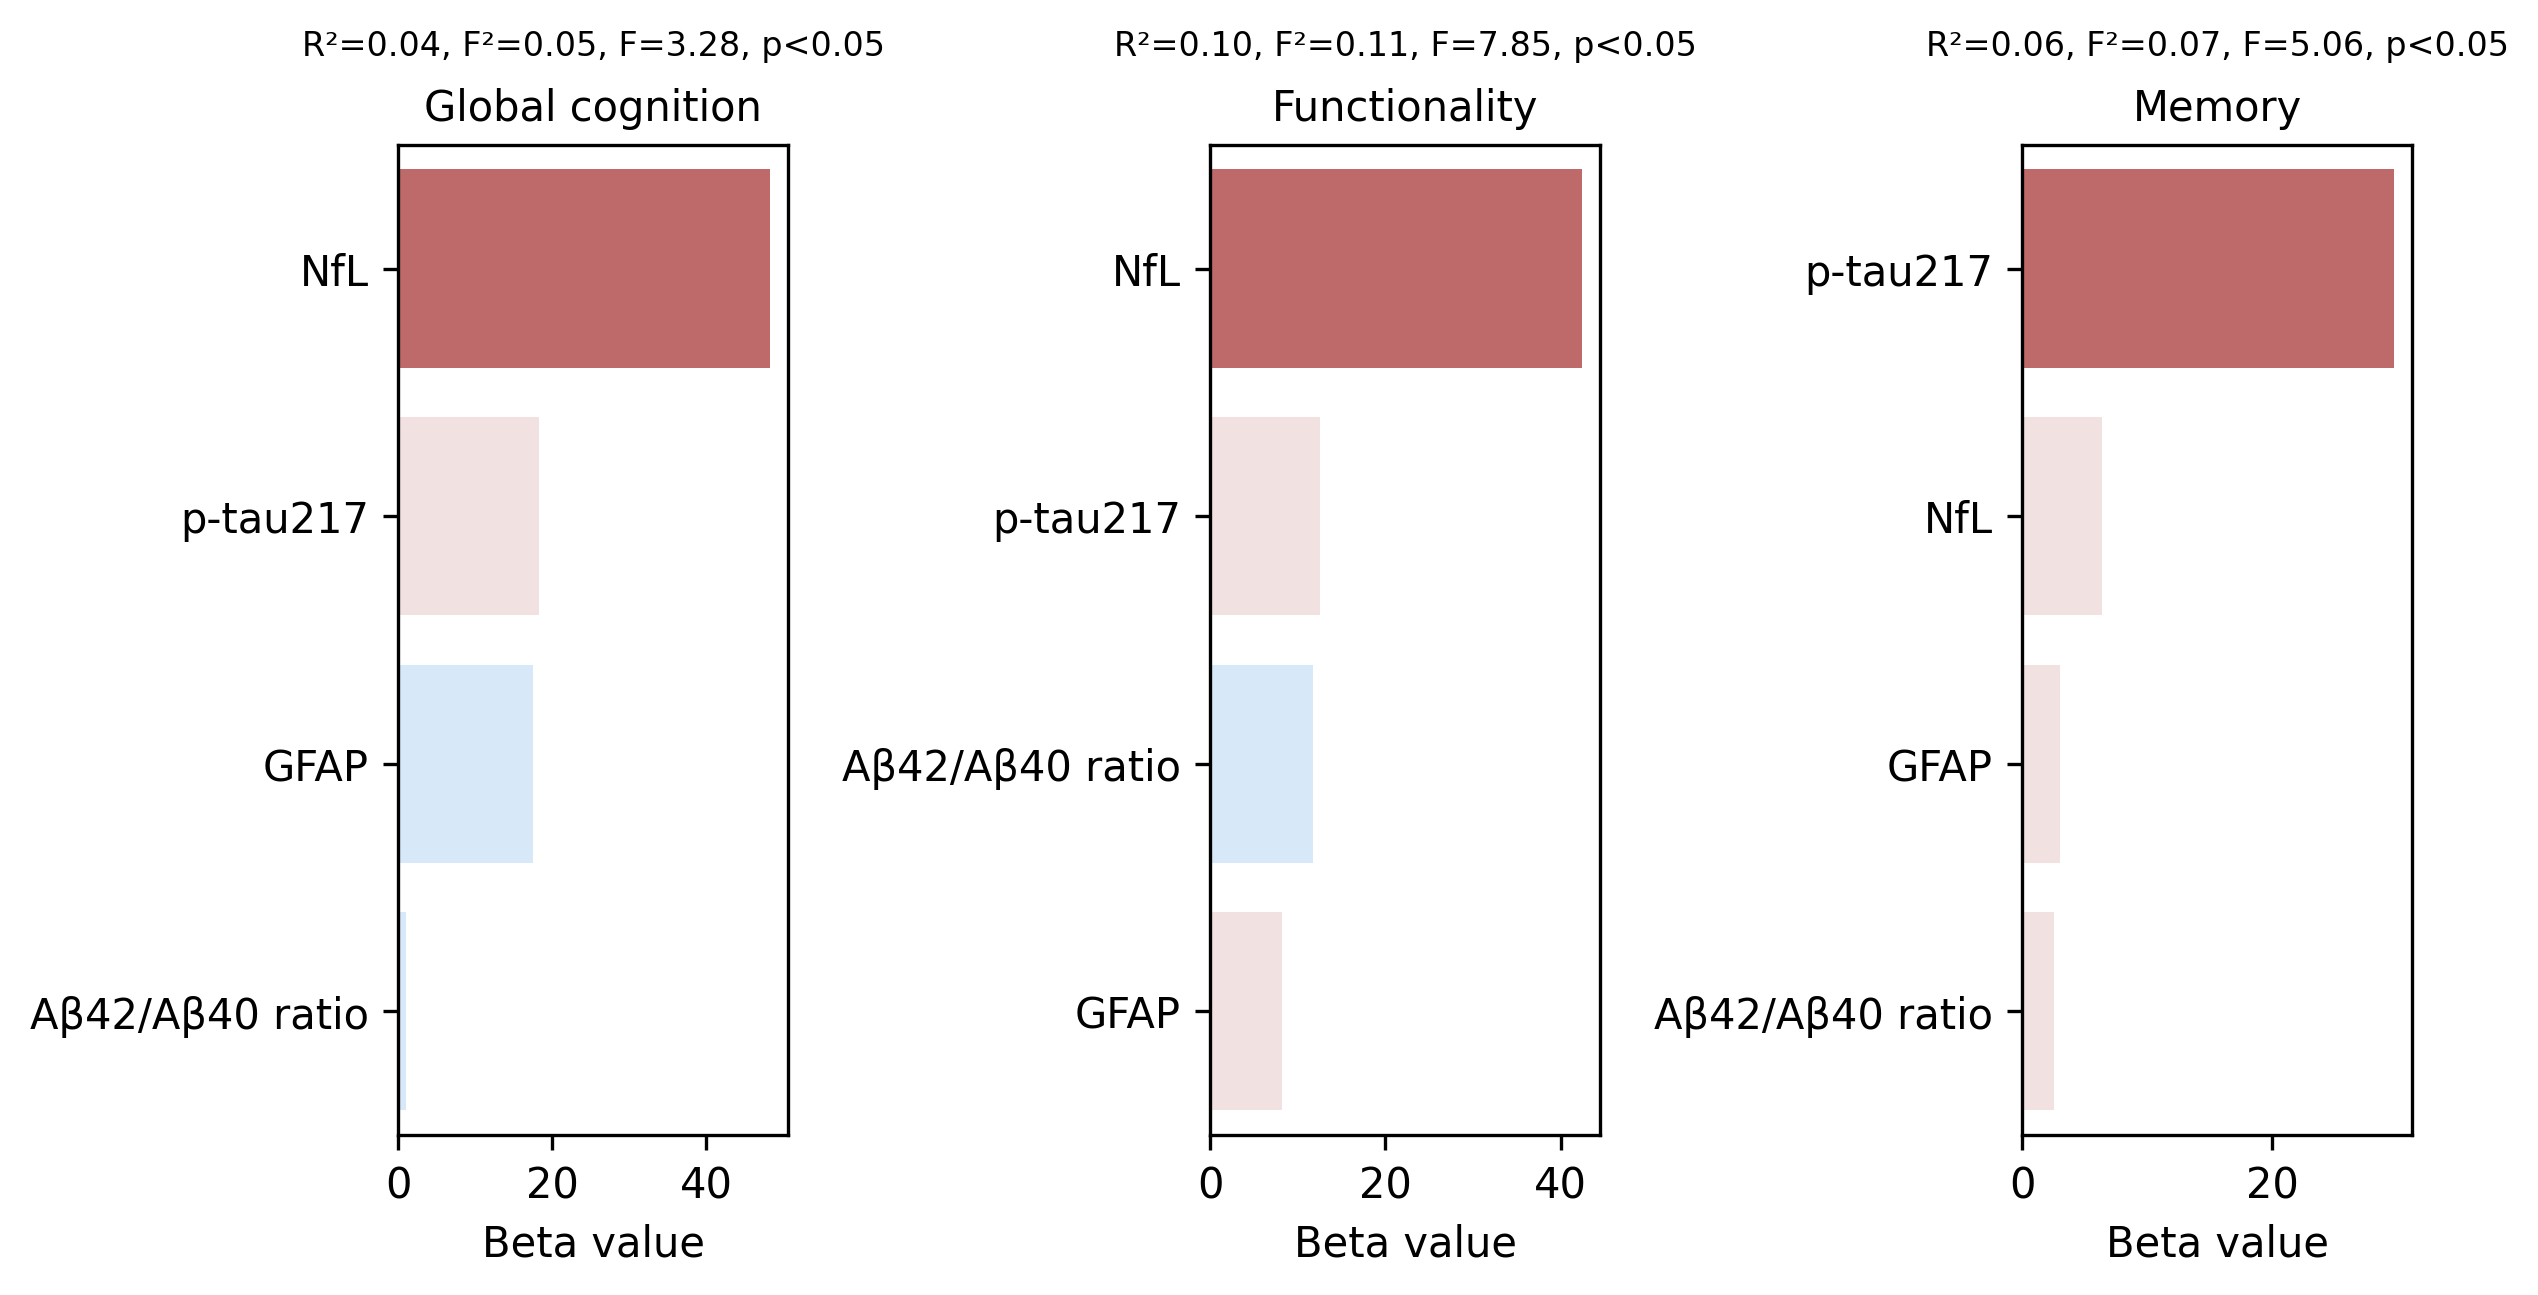

In [ ]:

coef_dfs = {}
fig, axes = plt.subplots(3, 3, figsize=(8.27, 11.69), dpi=300)
axes = axes.flatten()

for i, y_col in enumerate(y_columns):

    #na_cols = ['Ratio 42/40', 'GFAP', 'Nfl', 'ptau217', 'Sex', 'Age', 'Education', 'Global cognition',	'Memory',	'Attention',	'Language',	'Visuospatial',	'Executive function',	'Social cognition',	'Functionality']#,'APOE risk']


    current_df = df_cn_vs.copy()
    current_df.dropna(subset=predictors + [y_col], inplace=True)

    for col in predictors:
        if not pd.api.types.is_numeric_dtype(current_df[col]):
            current_df[col] = pd.to_numeric(current_df[col], errors='coerce')
    current_df.dropna(subset=predictors + [y_col], inplace=True)


    current_df.reset_index(drop=True, inplace=True)

    X_ = current_df[predictors]
    y = current_df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X_, y, train_size=0.80, test_size=0.20, random_state=RANDOM_SEED)

    scaler = MinMaxScaler(feature_range=(0.05, 0.95))
    scaling_data = scaler.fit_transform(X_train)
    X_s = pd.DataFrame(scaling_data, columns=X_train.columns,
                       index=X_train.index)
    X_train = X_s.copy()

    opt_Ridge = BayesSearchCV(
        Ridge(),
        {
            'alpha': (0.00001, 0.0001, 0.01, 0.001),
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            'max_iter': (1000, 10000, 100000, 1000000),
        },
        n_iter=10,
        cv=3,
        random_state=RANDOM_SEED
    )

    opt_Ridge.fit(X_train, y_train)

    [coef_df_Ridge, r_squared_Ridge, results_labels_df_Ridge] = Regression_Linear(
        X_, y, 1, 10, n_splits=5, model=Ridge(**opt_Ridge.best_params_))

    coef_dfs[y_col] = coef_df_Ridge
    ax = axes[i]
    df_betas = coef_df_Ridge.iloc[1:, [0, 3]].sort_values(by='Estimate mean', ascending=False)
    df_betas['label'] = df_betas.index
    #df_betas.loc[df_betas['p value'] < 0.05, 'label'] += ' *'

    df_betas['Estimate mean abs'] = df_betas['Estimate mean'].abs()

    df_betas['color'] = df_betas['Estimate mean'].apply(lambda x: 'dodgerblue' if x > 0 else 'indianred')
    df_betas = df_betas.sort_values(by='Estimate mean abs', ascending=False)
    df_betas['alpha'] = df_betas['p value'].apply(lambda x: 1 if x < 0.05 else 0.2)

    for index, row in df_betas.iterrows():
        sns.barplot(x=[row['Estimate mean abs']], y=[row['label']],
                    color=row['color'], orient='h', ax=ax, alpha=row['alpha'])

    ax.set_xlabel('Beta value', fontsize=10, fontname='Arial')
    ax.set_ylabel('')
    ax.set_title(y_col, fontsize=10, fontname='Arial')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')

    p_ = ''
    if coef_df_Ridge.loc['_intercept', 'F-p_value']<0.05:
        p_ = 'p<0.05'
    else:
        p_ = 'not significant'


    ax.text(0.5, 1.1, f"R²={r_squared_Ridge:.2f}, F²={coef_df_Ridge.loc['_intercept', 'F2']:.2f}, F={coef_df_Ridge.loc['_intercept', 'F']:.2f}, " + p_,
            ha='center', va='center', fontsize=8, transform=ax.transAxes, fontname='Arial')


    #coef_df_Ridge.to_excel(os.path.join('ResultGero', y_col +'.xlsx'))


for j in range(len(y_columns), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.savefig('high_res_plot.pdf', dpi=600)
plt.show()

In [ ]:
print(coef_dfs)


with pd.ExcelWriter('coef_dfs.xlsx', engine='openpyxl') as writer:
    for sheet_name, df in coef_dfs.items():
        df.to_excel(writer, sheet_name=sheet_name)


{'Global cognition':                  Estimate mean  Estimate std    t value   p value        R2  \
_intercept           78.252888      3.567056  18.400058  0.000000  0.044574   
Aβ42/Aβ40 ratio       0.983517      5.167542   0.112803  0.910266       NaN   
GFAP                 17.553102      5.514987   1.241959  0.215273       NaN   
NfL                 -48.221240      5.511836  -4.255584  0.000028       NaN   
p-tau217            -18.274446      5.571463  -1.728780  0.084931       NaN   

                  R2 adj   R2 [+-]        F2         mse  mse [+-]       rmse  \
_intercept       0.03441  0.110493  0.046653  446.370248  3.878828  21.127476   
Aβ42/Aβ40 ratio      NaN       NaN       NaN         NaN       NaN        NaN   
GFAP                 NaN       NaN       NaN         NaN       NaN        NaN   
NfL                  NaN       NaN       NaN         NaN       NaN        NaN   
p-tau217             NaN       NaN       NaN         NaN       NaN        NaN   

                 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>